In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

###Check GPU usage

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=aaf5599afa5f96955b9f580ade2d4dc75e517e4cb1f529e192fc28d707463854
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.9 GB  | Proc size: 154.2 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


###Import Trained Models

In [0]:
fridge = drive.CreateFile({'id': '1Zd6oD60cIRTHc-9YTXq9WyozPF6FifLE'}) 
fridge.GetContentFile('fridge.h5')
    
kettle = drive.CreateFile({'id': '10n45jsCVD-mC_GhRsKsJMeyU4Su2RG5Q'}) 
kettle.GetContentFile('kettle.h5')

washing_machine = drive.CreateFile({'id': '1eLPClsxSAi2P_DQq4_EePPE3xSMgC5Hf'}) 
washing_machine.GetContentFile('wm.h5')

dishwasher = drive.CreateFile({'id': '1TTQRdgGvwrYBIgkYBRRpl-J5sfn9BbEY'}) 
dishwasher.GetContentFile('dw.h5')

microwave = drive.CreateFile({'id': '1b4Y2FAACsNr_fmD5HzQES___CawYWqbf'}) 
microwave.GetContentFile('mw.h5')

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime 

import keras
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D 
from keras.layers import BatchNormalization, Input, Add
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

model = load_model('simo.h5')

Using TensorFlow backend.
W0803 15:28:05.786283 140638919251840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0803 15:28:05.881758 140638919251840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0803 15:28:05.883229 140638919251840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0803 15:28:05.906730 140638919251840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform inste

###Create functions to load house data, extract sequences, and select appliance midpoints



In [0]:
# Import house_key.py file which contains the id, and appliance numbers for every house.
house_key = drive.CreateFile({'id':'1IMYUxdxVtPfh0xrnef8--MoahwnANwgW'})
house_key.GetContentFile('house_key.py')
import house_key

house_info = house_key.make_house_info()

def import_house_data(selected_houses, appliance, house_info):
  '''Import raw house data from Drive. Resample to 1 minute intervals.
     Extract the aggregate and target appliance columns and place in
     a dataframe. Append each house to the end of the previous df.'''
  df = pd.DataFrame(columns = ['Aggregate'] + appliances)
  for house in selected_houses:
    id = house_info[house]['id']
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile(f'house{house}.csv')
    house_df = pd.read_csv(f'house{house}.csv', parse_dates=['Time'], index_col='Time').drop(['Unix', 'Issues'], axis = 1).resample('min').mean()
    house_df = house_df[['Aggregate']+[j for i, j in house_info[house].items() if i in appliances]].dropna()
    house_df.rename(columns={house_info[house][appliances[i]]:appliances[i] for i in range(len(appliances))}, inplace=True)
    df = df.append(house_df, sort = False)
  return df                              
                        
def make_sequences(df, n_steps):
  """Creates list of sequences of length n_steps
     that walks forward one timestep at a time""" 
  input_list = list(df['Aggregate'])
  output_list = []
  for i in range(len(input_list)):
    end_ix = i + n_steps
    if end_ix > len(input_list):
      break
    seq = input_list[i:end_ix]
    output_list.append(seq)
  X = np.array(output_list) 
  X = X.reshape(X.shape[0], X.shape[1], 1)
  return X

def get_midpoints(df, n_steps):
  '''Gets midpoints of a sliding sequence. Also gets midpoint of the sum of all selected appliances'''
  df_mid = df.iloc[n_steps//2:len(df)-n_steps//2, :]
  df_mid['Sum_of_appliances'] = df_mid['Aggregate'] - df_mid['Dishwasher'] - df_mid['Washing Machine'] - df_mid['Fridge'] - df_mid['Microwave']-df_mid['Kettle']
  app_df = df_mid.loc[:,['Dishwasher', 'Washing Machine', 'Fridge', 'Microwave', 'Kettle', 'Sum_of_appliances']]
  y = [np.array([app_df.loc[:,'Dishwasher']]), np.array([app_df.loc[:,'Washing Machine']]), np.array([app_df.loc[:,'Fridge']]), np.array([app_df.loc[:,'Microwave']]), np.array([app_df.loc[:,'Kettle']]), np.array([app_df.loc[:,'Sum_of_appliances']])]
  y_out = [] 
  for i in y:
    i = i.reshape(i.shape[1], i.shape[0])
    y_out.append(i)
  return y_out

![appliance list](https://drive.google.com/uc?export=view&id=12fOrgu6KKoICpQMSgtXm-Bi89_dafH12) 

## *REQUIRES INPUT* Specify target appliance and training/test houses. Import data for selected houses

In [0]:
appliances = ['Dishwasher', 'Washing Machine', 'Fridge', 'Microwave', 'Kettle']   #list of strings with first letters capitalized

# Use houses 2,3,9,11,15, or 20
training_houses = [15]    # must be a list of integers
test_house = [3]              # must be a list of integers             
n_steps = 199                  # length of sliding window. Should be an odd number

# Imports house data for target appliance and places in dataframes
df_train = import_house_data(training_houses, appliances, house_info)
df_test = import_house_data(test_house, appliances, house_info)

###Create training and test input sequences and target appliance midpoints

In [0]:
# Training sequences and midpoints
X_train = make_sequences(df_train, n_steps) 
y_train = get_midpoints(df_train, n_steps)

# Test sequences and midpoints
X_test = make_sequences(df_test, n_steps) 
y_test = get_midpoints(df_test, n_steps)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [0]:
import keras
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D 
from keras.layers import BatchNormalization, Input, Add
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

def build_ensemble():
  input = Input(shape=(n_steps, 1))
  appliance1 = load_model('dw.h5')
  appliance1.name = 'dw'
  appliance2 = load_model('wm.h5')
  appliance2.name = 'wm'
  appliance3 = load_model('fridge.h5')
  appliance3.name = 'fr'
  appliance4 = load_model('mw.h5')
  appliance4.name = 'mw'
  appliance5 = load_model('kettle.h5')
  appliance5.name = 'ket'
  
  out1 = appliance1(input)
  out1 = Dense(1, activation = 'relu', name = 'dishwasher')(out1)
  out2 = appliance2(input)
  out2 = Dense(1, activation = 'relu', name = 'washing_machine')(out2)
  out3 = appliance3(input)
  out3 = Dense(1, activation = 'relu', name = 'fridge')(out3)
  out4 = appliance4(input)
  out4 = Dense(1, activation = 'relu', name = 'microwave')(out4)
  out5 = appliance5(input)
  out5 = Dense(1, activation = 'relu', name = 'kettle')(out5)
  
  total = Add()([out1,out2,out3,out4,out5])

  model = Model(input, [out1,out2,out3,out4,out5,total])
  
  loss_weights = [1.0, 1.0, 0.1, 1.0, 1.0, 0.5]

  adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.00000008, decay=0.0, amsgrad=False)
  model.compile(loss='mse', optimizer=adam, loss_weights=loss_weights, metrics=['mae'])
  return model

In [0]:
model = build_ensemble()

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 199, 1)       0                                            
__________________________________________________________________________________________________
dw (Sequential)                 (None, 1)            968643      input_4[0][0]                    
__________________________________________________________________________________________________
wm (Sequential)                 (None, 1)            968643      input_4[0][0]                    
__________________________________________________________________________________________________
fr (Sequential)                 (None, 1)            968643      input_4[0][0]                    
__________________________________________________________________________________________________
mw (Sequen

#

###Train Model

In [0]:
batch_size = 1000
epochs = 30

early_stop = EarlyStopping(monitor='add_1_mean_absolute_error', min_delta=0.2, patience=3, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
history = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, verbose=1, callbacks=[early_stop])

model.save('simo_cnn.h5')

Epoch 1/30
705183/705183 [==============================] - 322s 457us/step - loss: 34367.1938 - dishwasher_loss: 1310.9503 - washing_machine_loss: 7839.6932 - fridge_loss: 22843.1349 - microwave_loss: 1453.3755 - kettle_loss: 7729.3559 - add_2_loss: 27499.0109 - dishwasher_mean_absolute_error: 13.5193 - washing_machine_mean_absolute_error: 20.3962 - fridge_mean_absolute_error: 102.3143 - microwave_mean_absolute_error: 10.8239 - kettle_mean_absolute_error: 8.7354 - add_2_mean_absolute_error: 55.7383
Epoch 2/30


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `add_1_mean_absolute_error` which is not available. Available metrics are: loss,dishwasher_loss,washing_machine_loss,fridge_loss,microwave_loss,kettle_loss,add_2_loss,dishwasher_mean_absolute_error,washing_machine_mean_absolute_error,fridge_mean_absolute_error,microwave_mean_absolute_error,kettle_mean_absolute_error,add_2_mean_absolute_error
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


705183/705183 [==============================] - 302s 428us/step - loss: 25096.2044 - dishwasher_loss: 687.3353 - washing_machine_loss: 4336.4303 - fridge_loss: 23774.2432 - microwave_loss: 877.6351 - kettle_loss: 4340.9900 - add_2_loss: 24952.7785 - dishwasher_mean_absolute_error: 10.4536 - washing_machine_mean_absolute_error: 17.2446 - fridge_mean_absolute_error: 104.0667 - microwave_mean_absolute_error: 11.4657 - kettle_mean_absolute_error: 13.7807 - add_2_mean_absolute_error: 47.4100
Epoch 3/30
705183/705183 [==============================] - 301s 427us/step - loss: 23763.2498 - dishwasher_loss: 636.3151 - washing_machine_loss: 3818.0403 - fridge_loss: 23605.5524 - microwave_loss: 739.1384 - kettle_loss: 3991.3820 - add_2_loss: 24435.6376 - dishwasher_mean_absolute_error: 10.4257 - washing_machine_mean_absolute_error: 16.6469 - fridge_mean_absolute_error: 104.1898 - microwave_mean_absolute_error: 11.3049 - kettle_mean_absolute_error: 14.0252 - add_2_mean_absolute_error: 45.8875
Epo

###Plot loss

In [0]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

### Predict Appliance load using aggregate

In [0]:
y_hat_test = model.predict(X_test)

In [0]:
y_hat_test[1].shape

(669966, 1)

###Reshape appliance predictions for plotting

In [0]:
fridge_out = fridge.reshape(fridge.shape[0])
kettle_out = kettle.reshape(kettle.shape[0])
dw_out = dw.reshape(dw.shape[0])
wm_out = wm.reshape(wm.shape[0])
mw_out = mw.reshape(mw.shape[0])


###Get aggregate for range of appliance predictions

In [0]:
aggregate = df_test.Aggregate[n_steps//2:len(df_test)-n_steps//2]

In [0]:
house_df = pd.read_csv('house2.csv', parse_dates=['Time'], index_col='Time').drop(['Unix', 'Issues'], axis = 1).resample('min').mean().dropna()

In [0]:
predictions = pd.DataFrame({'Aggregate': aggregate, 
                           'Fridge Predicted': fridge_out.astype('float64'), 
                           'Fridge Actual': house_df.Appliance1[n_steps//2:len(df_test)-n_steps//2],
                           'Kettle Predicted': kettle_out.astype('float64'), 
                           'Kettle Actual': house_df.Appliance8[n_steps//2:len(df_test)-n_steps//2],
                           'Dishwasher Predicted': dw_out.astype('float64'), 
                           'Dishwasher Actual': house_df.Appliance3[n_steps//2:len(df_test)-n_steps//2],
                           'Washing Machine Predicted':wm_out.astype('float64'),
                           'Washing Machine Actual': house_df.Appliance2[n_steps//2:len(df_test)-n_steps//2],
                           'Microwave Predicted': mw_out.astype('float64'),
                           'Microwave Actual': house_df.Appliance5[n_steps//2:len(df_test)-n_steps//2]
                           }, index = house_df.index[n_steps//2:len(df_test)-n_steps//2])

In [0]:
predictions.head()

,Aggregate,Fridge Predicted,Fridge Actual,Kettle Predicted,Kettle Actual,Dishwasher Predicted,Dishwasher Actual,Washing Machine Predicted,Washing Machine Actual,Microwave Predicted,Microwave Actual
Time,,,,,,,,,,,
2013-09-17 23:47:00,59.8,-6.294378,1.0,0.026848,0.0,3.282708,0.0,-0.096836,0.0,1.380744,0.0
2013-09-17 23:48:00,59.3,-2.190085,1.0,0.026848,0.0,2.894361,0.0,-0.034335,0.0,1.330021,0.0
2013-09-17 23:49:00,59.6,-2.294460,1.0,0.026848,0.0,2.824863,0.0,-0.070783,0.0,1.329255,0.0
2013-09-17 23:50:00,60.0,1.677305,1.0,0.026848,0.0,2.699587,0.0,0.210027,0.0,1.254286,0.0
2013-09-17 23:51:00,59.8,2.741750,1.0,0.026848,0.0,2.863316,0.0,0.395533,0.0,1.240273,0.0


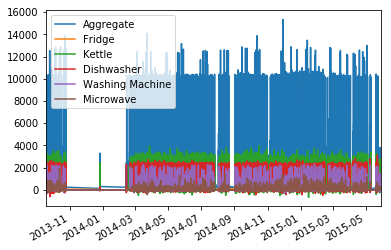

In [0]:
predictions.plot()

In [0]:
def get_mae(df):
    df['abs_err']= np.abs(df.y_test-df.y_test_hat)
    mae = np.round(df.abs_err.sum()/len(df),2)
    print(f'Mean absolute error: {mae}')
    return mae

def get_sae(df):
    r = df.y_test.sum()
    r_hat = df.y_test_hat.sum()
    sae = np.round(np.abs(r_hat-r)/r, 4)
    print(f'Signal Aggregate Error: {sae}')
    return sae
  
def get_epd(df_test, y_hat_test_out):
    app_test_df = df_test.Appliance[n_steps//2:len(df_test)-n_steps//2]
    df_out =  pd.DataFrame({'Test':app_test_df,'Predicted':y_hat_test_out,}, index=app_test_df.index)
    df_out = df_out.resample('D').sum()/60
    df_out['EPD'] = np.abs(df_out.Test-df_out.Predicted)
    epd = np.round(df_out.EPD.sum()/len(df_out), 2)
    print(f'Average Energy Per Day Error (EPD, W-hr): {epd}')
    return epd  
  
#y_hat_out = y_hat.reshape(y_hat.shape[0])
y_hat_test_out = y_hat_test.reshape(y_hat_test.shape[0])

#y_train_out = y_train.reshape(y_train.shape[0])
y_test_out = y_test.reshape(y_test.shape[0])

#train_results = pd.DataFrame({'y_train':y_train_out, 'y_hat_train': y_hat_train_out})
test_results = pd.DataFrame({'y_test': y_test_out, 'y_test_hat': y_hat_test_out})
  
mae = get_mae(test_results)
sae = get_sae(test_results)
epd = get_epd(df_test, y_hat_test_out)

Mean absolute error: 80.75
Signal Aggregate Error: 0.3983


### Export test data as CSV file

In [0]:
#train_csv = train_results.to_csv('train_results.csv', index = None, header=True)
test_csv = predictions.to_csv('house_2_predictions.csv', index = 'Time', header=True)

###Plot Test Data and Model Predictions|

In [0]:
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.themes import built_in_themes
from bokeh.io import curdoc

output_notebook()
curdoc().theme = 'dark_minimal'

p = figure(plot_width=1200, plot_height=600, x_axis_type="datetime")
p.xaxis.axis_label = "Time"
p.yaxis.axis_label = "Watts"

x0 = np.array(predictions.index)
y0 = np.array(predictions['Aggregate'])

y1 = np.array(predictions['Fridge'])
y2 = np.array(predictions['Kettle'])
y3 = np.array(predictions['Dishwasher'])
y4 = np.array(predictions['Washing Machine'])
y5 = np.array(predictions['Microwave'])

p.line(x0, y0, legend= "Aggregate", line_color='green')
p.line(x0, y1, legend= "Fridge", line_color='red')
p.line(x0, y2, legend= "Kettle", line_color='yellow')
p.line(x0, y3, legend= "Dishwasher", line_color='blue')
p.line(x0, y4, legend= "Washing Machine", line_color='orange')
p.line(x0, y5, legend= "Microwave", line_color='teal')

show(p)

Loading BokehJS ...